# ***STEP 1 | DATA UPLOAD***

In [ ]:
import os
from zipfile import ZipFile
from google.colab import files

# Install Kaggle package
!pip install kaggle

# Upload Kaggle API key
files.upload()

# Move API key to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download "fer2013" dataset
!kaggle datasets download -d msambare/fer2013

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/fer2013.zip'
extracted_folder_path = '/content/fer2013/'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Unzip the contents of the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the files in the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print("Contents of the extracted folder:", extracted_files)

Saving kaggle.json to kaggle.json
 96% 58.0M/60.3M [00:03<00:00, 24.6MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.3MB/s]
Contents of the extracted folder: ['test', 'train']


# ***STEP 2 | EXPLORATORY DATA ANALYSIS***

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model




# ***STEP 2.1 | DATA EXPLORATION***

In [ ]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/fer2013/train/"
test_dir = "/content/fer2013/test/"
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

print("Train Count:")
print(train_count)

print("\nTest Count:")
print(test_count)

Train Count:
       disgust  neutral  angry  surprise  fear  happy   sad
train      436     4965   3995      3171  4097   7215  4830

Test Count:
      disgust  neutral  angry  surprise  fear  happy   sad
test      111     1233    958       831  1024   1774  1247


# ***STEP 2.2 | DATA VISUALIZATION***

<Axes: >

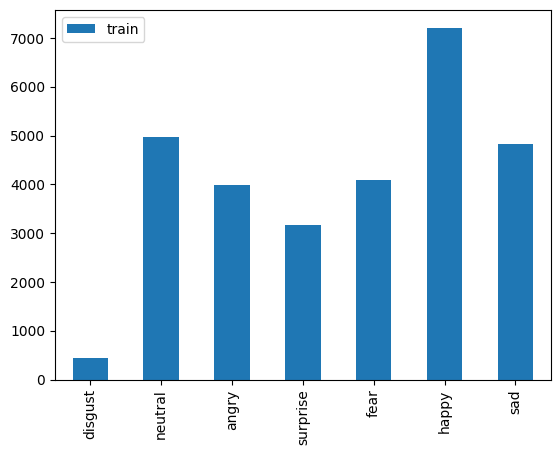

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

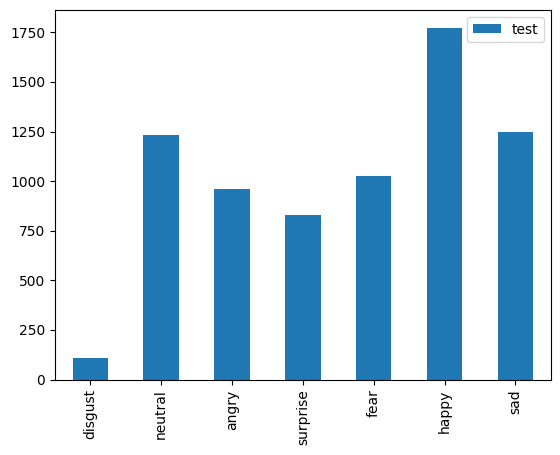

In [ ]:
test_count.transpose().plot(kind='bar')

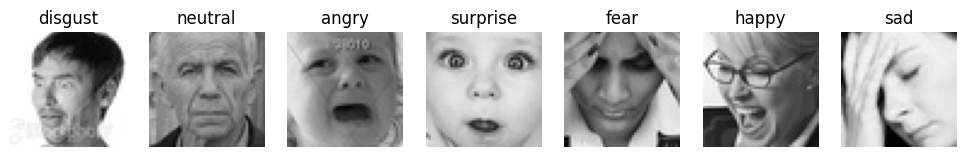

In [ ]:
plt.figure(figsize=(14, 22))
i = 1

for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression + '/' + os.listdir(train_dir + expression)[5]))
    plt.subplot(1, 8, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()


In [ ]:

# Data Augmentation Configuration
data_gen_args = dict(
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Training & Validation Data Generator
datagen = ImageDataGenerator(**data_gen_args)
training_set = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale',
    seed=42
)

validation_set = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale',
    seed=42
)

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#labels
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# ***STEP 3 | MODEL CREATION***

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
import matplotlib.pyplot as plt

# Define constants
row, col = 48, 48
num_classes = 7
weight_decay = 1e-4

# Model creation
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(row, col, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(128, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (4, 4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))

# Output layer with softmax activation for probabilities
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                       

# ***STEP 4 | MODEL TRAINING***

In [ ]:
# Define callbacks
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=6),
    ModelCheckpoint(
        filepath='model.weights.best.hdf5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]

# Define data generators
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Training & Validation Data Generator
training_set = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale',
    seed=42
)

validation_set = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale',
    seed=42
)

# Define steps per epoch and validation steps
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=100,
    validation_data=validation_set,
    validation_steps=len(validation_set),
    callbacks=checkpointer
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 2.3754 - accuracy: 0.2000
Epoch 1: val_accuracy improved from -inf to 0.17366, saving model to model.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 55s 105ms/step - loss: 2.3754 - accuracy: 0.2000 - val_loss: 2.0428 - val_accuracy: 0.1737
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 2.2165 - accuracy: 0.2195
Epoch 2: val_accuracy improved from 0.17366 to 0.25954, saving model to model.weights.best.hdf5
359/359 [==============================] - 33s 91ms/step - loss: 2.2165 - accuracy: 0.2195 - val_loss: 1.9545 - val_accuracy: 0.2595
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 2.1454 - accuracy: 0.2241
Epoch 3: val_accuracy improved from 0.25954 to 0.27957, saving model to model.weights.best.hdf5
359/359 [==============================] - 34s 94ms/step - loss: 2.1454 - accuracy: 0.2241 - val_loss: 1.9373 - val_accuracy: 0.2796
Epoch 4/100
359/359 [==============================] - ETA: 0s - loss: 2.0729 - accuracy: 0.2404
Epoch 4: val_accuracy improved from 0.27957 to 0.28723, saving model to model.weights.best.hdf5
359/359 [============

# ***STEP 5 | MODEL EVALUATION AND VISUALIZATION***

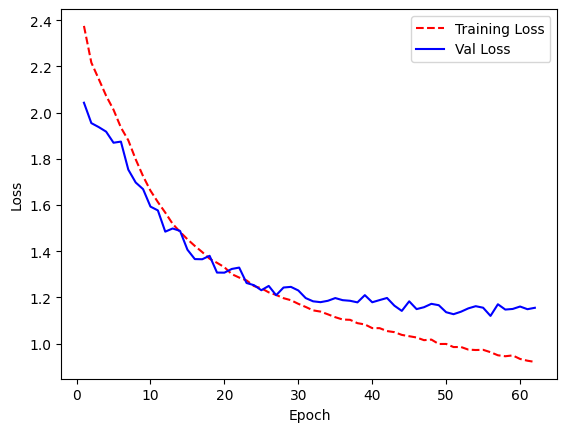

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

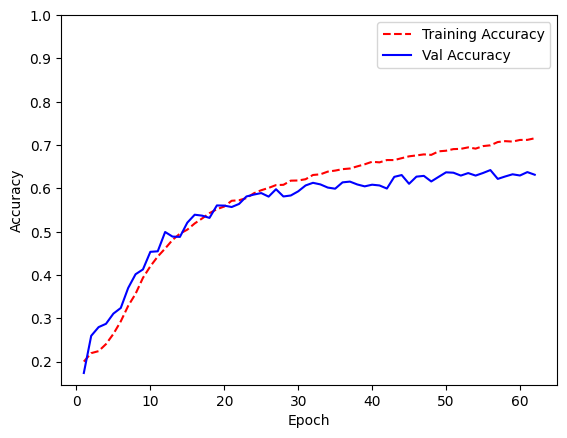

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)
# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
# Confusion matrix code snippet
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


# Accuracy code snippet
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy * 100}%")

# Precision, recall, and F1-score code snippets
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

for i in range(len(emotion_labels)):
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"\nClass: {emotion_labels[i]}")
    print(f"Precision: {precision * 100}%")
    print(f"Recall: {recall * 100}%")
    print(f"F1-Score: {f1_score}")




113/113 [==============================] - 3s 27ms/step
Confusion Matrix:
[[142  16 117 223 184 176 100]
 [ 17   2  17  29  16  16  14]
 [150  17 132 241 210 158 116]
 [238  24 226 440 348 296 202]
 [207  11 171 272 228 197 147]
 [184  15 192 317 233 187 119]
 [103  13 109 221 174 132  79]]
Accuracy: 16.857063248815827%

Class: Angry
Precision: 13.640730067243034%
Recall: 14.822546972860126%
F1-Score: 0.14207103551775885

Class: Disgust
Precision: 2.0408163265306123%
Recall: 1.8018018018018018%
F1-Score: 0.019138755980861243

Class: Fear
Precision: 13.692946058091287%
Recall: 12.890625%
F1-Score: 0.13279678068410464

Class: Happy
Precision: 25.243832472748135%
Recall: 24.80270574971815%
F1-Score: 0.2502132499289167

Class: Neutral
Precision: 16.367552045944006%
Recall: 18.491484184914842%
F1-Score: 0.17364813404417365

Class: Sad
Precision: 16.092943201376936%
Recall: 14.995990376904572%
F1-Score: 0.1552511415525114

Class: Surprise
Precision: 10.167310167310168%
Recall: 9.506618531889

113/113 [==============================] - 3s 22ms/step


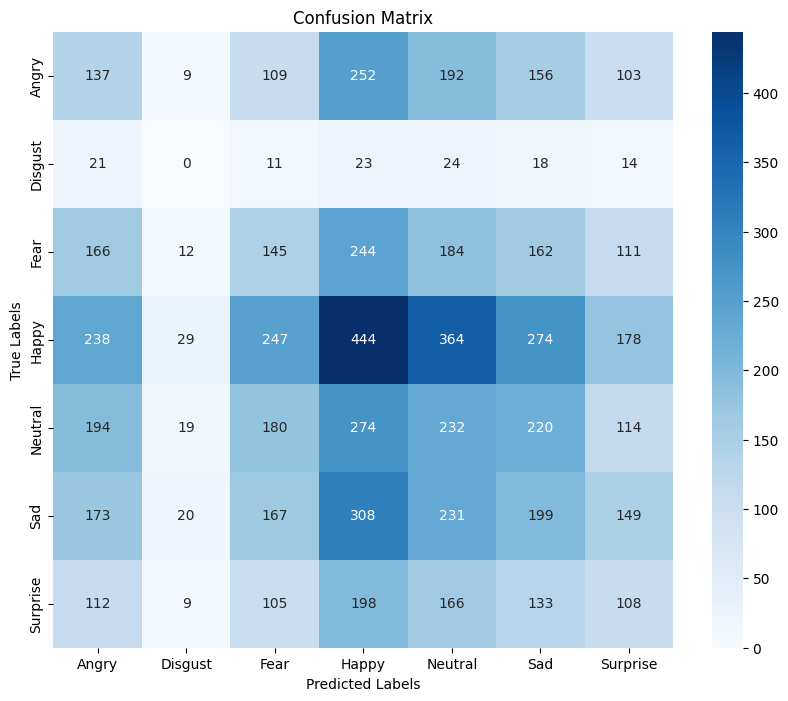

Accuracy: 17.623293396489274%
Classification Report:
               precision    recall  f1-score   support

       Angry       0.13      0.14      0.14       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.15      0.14      0.15      1024
       Happy       0.25      0.25      0.25      1774
     Neutral       0.17      0.19      0.18      1233
         Sad       0.17      0.16      0.17      1247
    Surprise       0.14      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix code snippet
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Accuracy code snippet
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy * 100}%")

# Precision, recall, and F1-score code snippets
classification_rep = classification_report(y_true, y_pred_classes, target_names=emotion_labels)
print("Classification Report:\n", classification_rep)


113/113 [==============================] - 3s 23ms/step
ROC-AUC: 0.5051017080808753


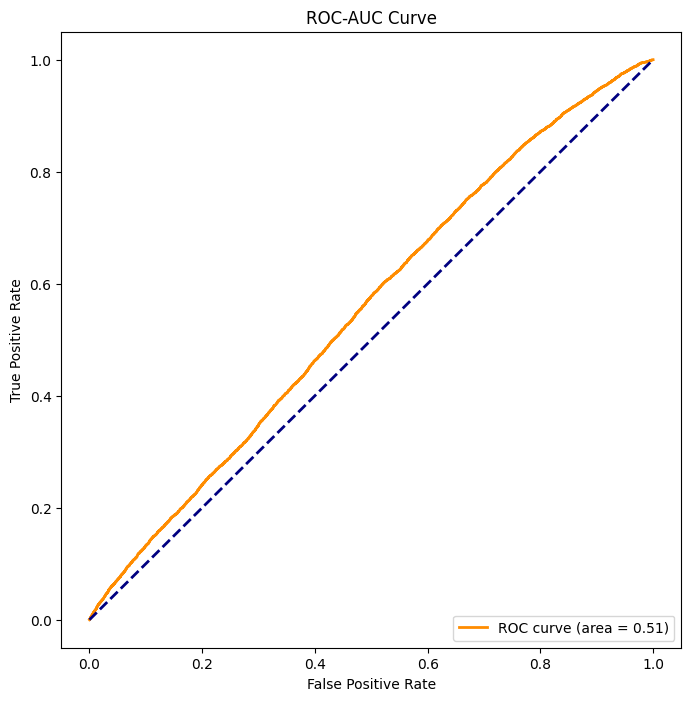

In [ ]:
# ROC-AUC code snippet with multiclass labels
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get class probabilities instead of class labels
y_pred_probs = model.predict(test_set)

# Convert multiclass labels to binary format
lb = LabelBinarizer()
y_true_binary = lb.fit_transform(test_set.classes)

# Assuming the positive class is at index 1
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')

print(f"ROC-AUC: {roc_auc}")

# Plot ROC-AUC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()


2/2 [==============================] - 1s 13ms/step


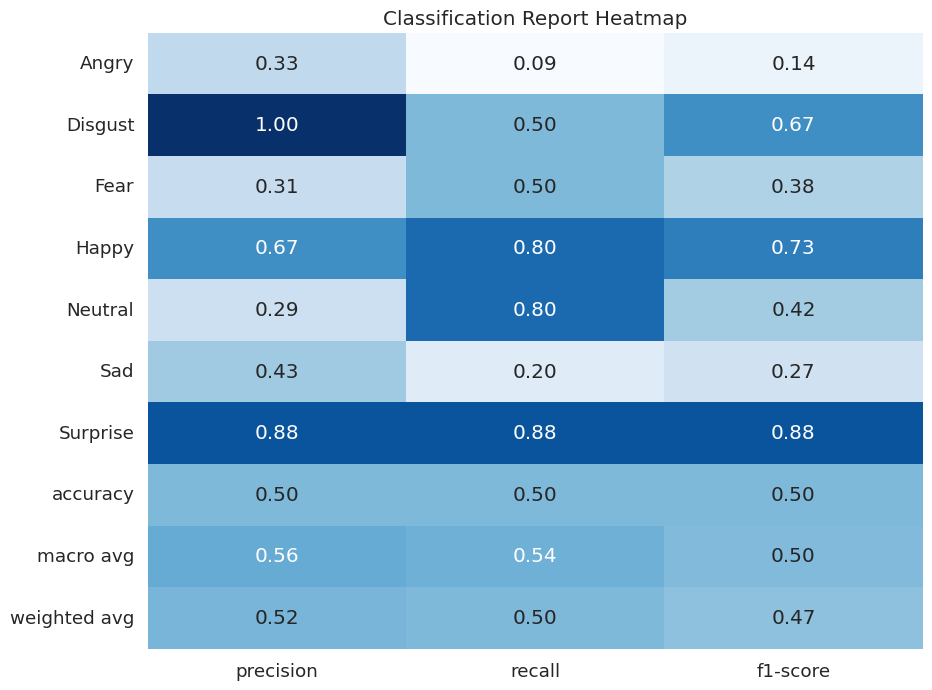

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming 'model' is your trained model and 'test_set' is the test data generator
x_test, y_true = next(test_set)

# Make predictions using the trained model
predictions = model.predict(x_test)

# Convert one-hot encoded predictions and true labels back to categorical labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_true, axis=1)

# Define the emotions list (modify it based on your actual class labels)
emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Generate classification report
class_report = classification_report(y_true, y_pred, labels=np.unique(y_true), target_names=emotions, output_dict=True)

# Convert classification report to a DataFrame for visualization
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap')
plt.show()


# ***STEP 6 | SAVE THE MODEL***

In [ ]:
model.save("fer7_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 15ms/step


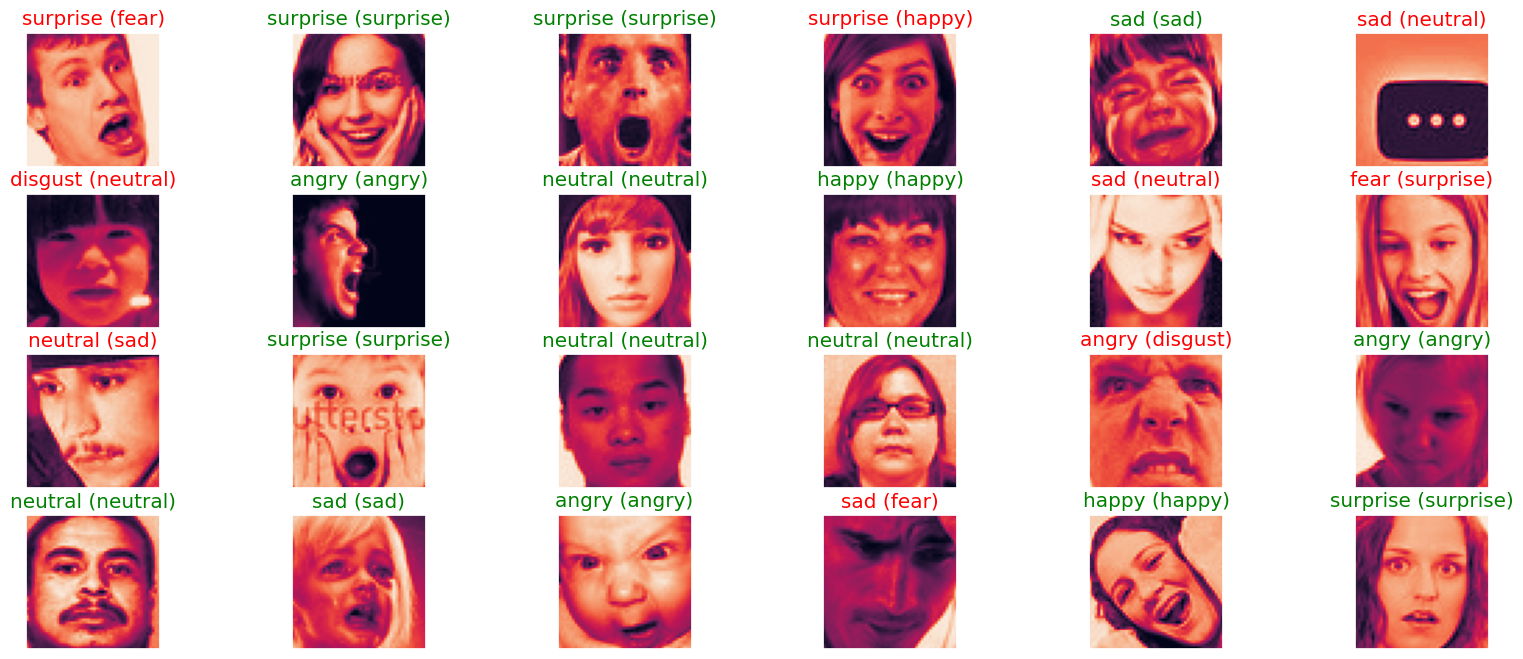

In [ ]:


# next function assigns one batch to variables, i.e., x_test, y_test will have 64 images
x_test, y_test = next(test_set)

# Assuming 'model' is your trained model
predict = model.predict(x_test)

# Assuming 'test_set' is a generator with class indices defined
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}

# Visualization
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))

    # Get the predicted and true labels
    predict_index = class_labels[np.argmax(predict[index])]
    true_index = class_labels[np.argmax(y_test[index])]

    # Set the title with predicted and true labels, and color it based on correctness
    ax.set_title("{} ({})".format(predict_index, true_index),
                 color=("green" if predict_index == true_index else "red"))

plt.show()


# ***STEP 7 | IMAGE ULOAD AND EMOTION DETECTION***

Saving mixed-expression-worried-happy.png to mixed-expression-worried-happy.png


1/1 [==============================] - 0s 216ms/step
Emotion Probabilities:
Angry: 2.54%
Disgust: 1.52%
Fear: 14.42%
Happy: 74.07%
Neutral: 1.86%
Sad: 3.86%
Surprise: 1.72%


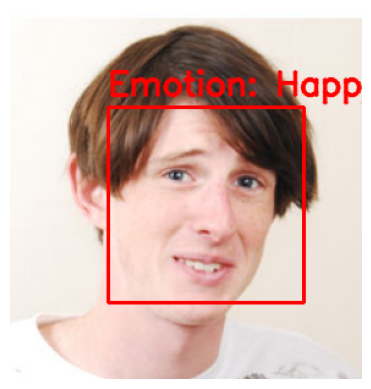

In [ ]:
import cv2
import numpy as np
from google.colab import files
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = keras.models.load_model("/content/fer2013/fer7_model.h5")

# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define emotion labels
emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Function to detect facial emotion in a static image
def detect_emotion_in_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image for the model
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255

        # Make prediction using the trained model
        predictions = model.predict(img_pixels)[0]

        # Print probabilities for each emotion
        print("Emotion Probabilities:")
        for i, emotion_prob in enumerate(predictions):
            print(f"{emotions[i]}: {emotion_prob * 100:.2f}%")

        # Get the predicted emotion
        max_index = np.argmax(predictions)
        predicted_emotion = emotions[max_index]

        # Display the emotion text on the image for each face
        cv2.putText(img_rgb, f"Emotion: {predicted_emotion}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the image with detected emotions
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Function to upload and detect emotion for multiple images
def detect_emotion_in_uploaded_images():
    uploaded = files.upload()
    for filename, content in uploaded.items():
        nparr = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        emotion_probabilities = detect_emotion_in_image(img)

# Detect emotion in uploaded images
detect_emotion_in_uploaded_images()


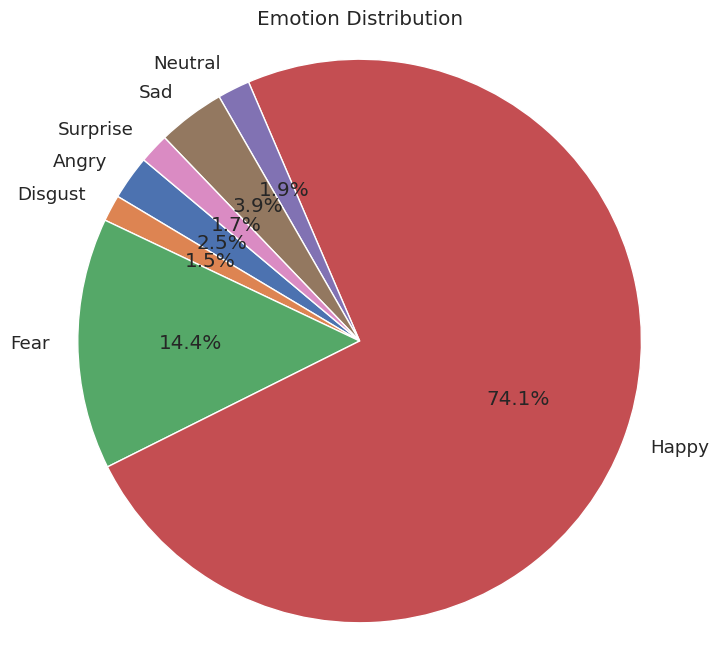

In [ ]:

import matplotlib.pyplot as plt

# Function to create a pie chart of emotion distribution
def create_pie_chart(emotion_probabilities):
    emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    plt.figure(figsize=(8, 8))
    for prob in emotion_probabilities:
        plt.pie(prob, labels=emotions, autopct='%1.1f%%', startangle=140)
        plt.title('Emotion Distribution')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()


In [ ]:
# Function to analyze mental health disorders based on emotion probabilities
def analyze_mental_health_disorders(emotion_probabilities):
    # Define mental health disorders corresponding to each emotion
    disorders = {
        "Angry": "PTSD",
        "Disgust": "Depression",
        "Fear": "Anxiety",
        "Happy": "Bipolar Disorder",
        "Neutral": "Schizophrenia",
        "Sad": "Depression",
        "Surprise": "PTSD"
    }

    # Define probabilities of mental health disorders
    disorder_probabilities = {
        "Bipolar Disorder": 0.0,
        "Depression": 0.0,
        "Anxiety": 0.0,
        "PTSD": 0.0,
        "Schizophrenia": 0.0
    }

    # Calculate probabilities for each mental health disorder based on emotions
    for emotion, probability in emotion_probabilities.items():
        disorder = disorders[emotion]
        disorder_probabilities[disorder] += probability

    # Normalize probabilities so that their sum equals 100%
    total_probability = sum(disorder_probabilities.values())
    for disorder in disorder_probabilities:
        disorder_probabilities[disorder] /= total_probability

    # Sort the mental health disorders by their probabilities in descending order
    sorted_disorders = sorted(disorder_probabilities.items(), key=lambda x: x[1], reverse=True)

    return sorted_disorders

# Detect emotion in uploaded images and analyze mental health disorders based on emotion probabilities
def detect_emotion_and_analyze_mental_health():
    uploaded = files.upload()
    for filename, content in uploaded.items():
        nparr = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        emotion_probabilities = detect_emotion_in_image(img)
        sorted_disorders = analyze_mental_health_disorders(emotion_probabilities)

        # Output the likelihood of mental health disorders
        print("Likelihood of Mental Health Disorders:")
        for disorder, probability in sorted_disorders:
            print(f"{disorder}: {probability * 100:.2f}%")

# Detect emotion in uploaded images and analyze mental health disorders
detect_emotion_and_analyze_mental_health()


Likelihood of Mental Health Disorders:
Bipolar Disorder: 74.08%
Anxiety: 14.42%
Depression: 5.38%
PTSD: 4.26%
Schizophrenia: 1.86%


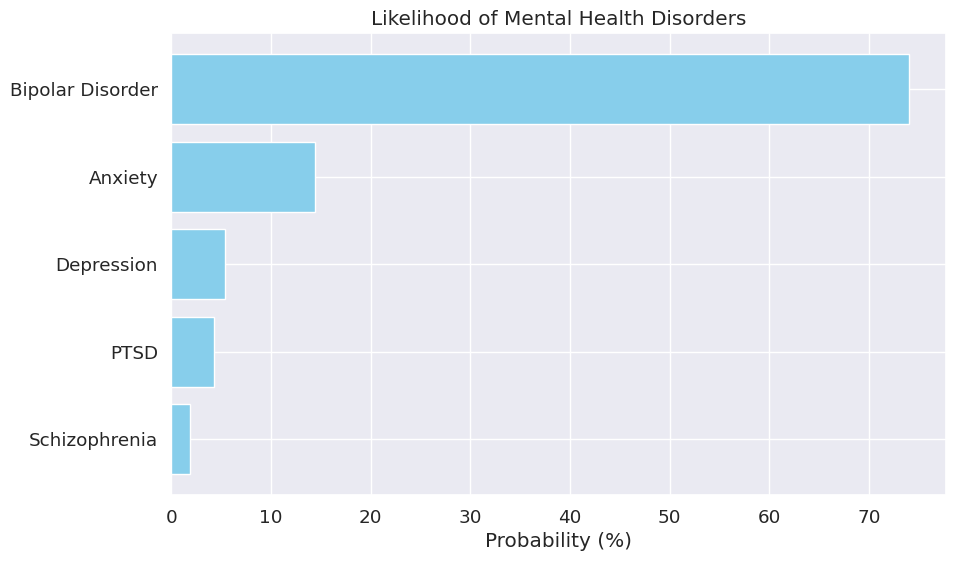

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize likelihood of mental health disorders
def visualize_mental_health_disorders(sorted_disorders1):
    disorders, probabilities = zip(*sorted_disorders1)

    # Convert probabilities to percentages by multiplying by 100
    probabilities = [probability * 100 for probability in probabilities]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(disorders)), probabilities, color='skyblue')
    plt.yticks(range(len(disorders)), disorders)
    plt.xlabel('Probability (%)')
    plt.title('Likelihood of Mental Health Disorders')
    plt.gca().invert_yaxis()  # Invert y-axis to display disorders in descending order
    plt.show()

# Visualize likelihood of mental health disorders
visualize_mental_health_disorders(sorted_disorders1)




In [ ]:
# Function to analyze mental health disorders based on emotion probabilities
def analyze_mental_health_disorders(emotion_probabilities):
    # Define mental health disorders corresponding to each emotion
    disorders = {
        "Angry": "Oppositional Defiant Disorder (ODD)",
        "Disgust": "Specific Phobia",
        "Fear": "Generalized Anxiety Disorder (GAD)",
        "Happy": "Bipolar Disorder",
        "Neutral": "Schizotypal Personality Disorder",
        "Sad": "Major Depressive Disorder (MDD)",
        "Surprise": "Post-Traumatic Stress Disorder (PTSD)"
    }

    # Define probabilities of mental health disorders
    disorder_probabilities = {
        "Oppositional Defiant Disorder (ODD)": 0.0,
        "Specific Phobia": 0.0,
        "Generalized Anxiety Disorder (GAD)": 0.0,
        "Bipolar Disorder": 0.0,
        "Schizotypal Personality Disorder": 0.0,
        "Major Depressive Disorder (MDD)": 0.0,
        "Post-Traumatic Stress Disorder (PTSD)": 0.0
    }

    # Calculate probabilities for each mental health disorder based on emotions
    for emotion, probability in emotion_probabilities.items():
        disorder = disorders[emotion]
        disorder_probabilities[disorder] += probability

    # Normalize probabilities so that their sum equals 100%
    total_probability = sum(disorder_probabilities.values())
    for disorder in disorder_probabilities:
        disorder_probabilities[disorder] /= total_probability

    # Sort the mental health disorders by their probabilities in descending order
    sorted_disorders2 = sorted(disorder_probabilities.items(), key=lambda x: x[1], reverse=True)

    return sorted_disorders2

# Detect emotion in uploaded images and analyze mental health disorders based on emotion probabilities
def detect_emotion_and_analyze_mental_health():
    uploaded = files.upload()
    for filename, content in uploaded.items():
        nparr = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        emotion_probabilities = detect_emotion_in_image(img)
        sorted_disorders2 = analyze_mental_health_disorders(emotion_probabilities)

        # Output the likelihood of mental health disorders
        print("Likelihood of Mental Health Disorders:")
        for disorder, probability in sorted_disorders2:
            print(f"{disorder}: {probability * 100:.2f}%")

# Detect emotion in uploaded images and analyze mental health disorders
detect_emotion_and_analyze_mental_health()


Likelihood of Mental Health Disorders:
Bipolar Disorder: 74.08%
Generalized Anxiety Disorder (GAD): 14.42%
Major Depressive Disorder (MDD): 3.86%
Oppositional Defiant Disorder (ODD): 2.54%
Schizotypal Personality Disorder: 1.86%
Post-Traumatic Stress Disorder (PTSD): 1.72%
Specific Phobia: 1.52%


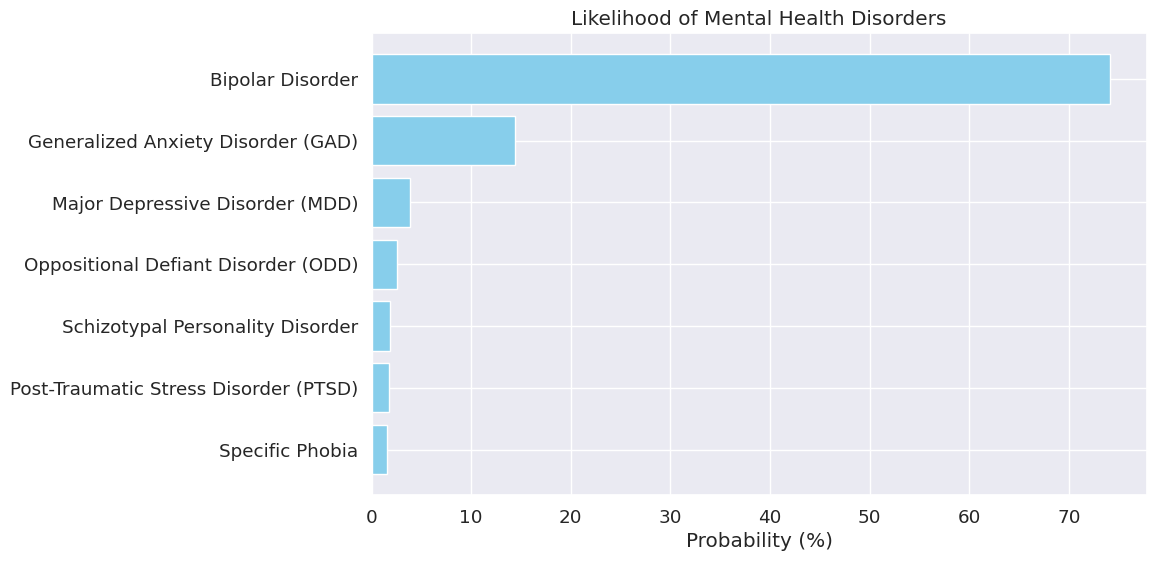

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize likelihood of mental health disorders
def visualize_mental_health_disorders(sorted_disorders2):
    disorders, probabilities = zip(*sorted_disorders2)

    # Convert probabilities to percentages by multiplying by 100
    probabilities = [probability * 100 for probability in probabilities]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(disorders)), probabilities, color='skyblue')
    plt.yticks(range(len(disorders)), disorders)
    plt.xlabel('Probability (%)')
    plt.title('Likelihood of Mental Health Disorders')
    plt.gca().invert_yaxis()  # Invert y-axis to display disorders in descending order
    plt.show()

# Visualize likelihood of mental health disorders
visualize_mental_health_disorders(sorted_disorders2)


# ***END...***